In [17]:
import numpy as np
import glob, os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, cohen_kappa_score, roc_auc_score, average_precision_score
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr


In [18]:
import tensorflow as tf
import keras.src.backend.tensorflow.numpy as tfnumpy

def tf_signbit(x):
    """Safe TensorFlow-only signbit implementation."""
    x = tf.cast(x, tf.float32)
    x_int = tf.bitcast(x, tf.int32)

    # define mask in uint32 then cast → avoids OverflowError
    mask = tf.cast(tf.constant(0x80000000, dtype=tf.uint32), tf.int32)

    return tf.not_equal(tf.bitwise.bitwise_and(x_int, mask), 0)

# ✅ Patch keras backend
tfnumpy.signbit = tf_signbit
print("✅ Patched signbit safely")


✅ Patched signbit safely


In [19]:

# ----------------------------
# LOAD DATA
# ----------------------------
data_dir = "D:\\office work\\Desktop\\I22-1901-DL-ASG-01\\Dataset\\annotations"
images_dir = "D:\\office work\\Desktop\\I22-1901-DL-ASG-01\\Dataset\\images"

exp_files = sorted(glob.glob(os.path.join(data_dir, "*_exp.npy")))

filepaths, y_expr, y_val, y_aro = [], [], [], []
for f in exp_files:
    idx = os.path.basename(f).split("_")[0]  # e.g. "0" from "0_exp.npy"
    
    img_path = os.path.join(images_dir, f"{idx}.jpg")
    exp_path = os.path.join(data_dir, f"{idx}_exp.npy")
    val_path = os.path.join(data_dir, f"{idx}_val.npy")
    aro_path = os.path.join(data_dir, f"{idx}_aro.npy")

    if os.path.exists(img_path):  # avoid missing
        filepaths.append(img_path)
        y_expr.append(np.load(exp_path))
        y_val.append(np.load(val_path))
        y_aro.append(np.load(aro_path))

filepaths = np.array(filepaths)
y_expr = tf.keras.utils.to_categorical(np.array(y_expr, dtype=np.int32), num_classes=8)
y_val = np.array(y_val, dtype=np.float32)
y_aro = np.array(y_aro, dtype=np.float32)

print("Samples:", len(filepaths))


Samples: 3999


In [20]:

# ----------------------------
# DATA PIPELINE
# ----------------------------
IMG_SIZE = 224
BATCH_SIZE = 32

def load_and_preprocess(img_path, label_expr, label_val, label_aro):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    img = preprocess_input(img)  # ResNet preprocessing
    return img, {
        "emotion_output": label_expr,
        "valence_output": label_val,
        "arousal_output": label_aro,
    }

dataset = tf.data.Dataset.from_tensor_slices((filepaths, y_expr, y_val, y_aro))
dataset = dataset.shuffle(buffer_size=len(filepaths))


In [21]:

# Split train / val
train_size = int(0.8 * len(filepaths))
train_ds = dataset.take(train_size)
val_ds = dataset.skip(train_size)

# Augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])


In [22]:

train_ds = train_ds.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))
train_ds = train_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_ds = val_ds.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


In [23]:

# ----------------------------
# MODEL (ResNet)
# ----------------------------
base_model = ResNet50(weights='imagenet',
                      include_top=False,
                      input_tensor=Input(shape=(IMG_SIZE, IMG_SIZE, 3)))
base_model.trainable = False  # Freeze for transfer learning

x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.3)(x)

emotion_output = Dense(8, activation='softmax', name="emotion_output")(x)
valence_output = Dense(1, activation='tanh', name="valence_output")(x)
arousal_output = Dense(1, activation='tanh', name="arousal_output")(x)

model = Model(inputs=base_model.input,
              outputs=[emotion_output, valence_output, arousal_output])

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss={
        "emotion_output": "categorical_crossentropy",
        "valence_output": "mse",
        "arousal_output": "mse",
    },
    metrics={
        "emotion_output": ["accuracy"],
        "valence_output": ["mse"],
        "arousal_output": ["mse"],
    }
)

model.summary()


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_5[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,608,202 (90.06 MB)

 Trainable params: 20,490 (80.04 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [24]:

# ----------------------------
# TRAINING
# ----------------------------
early_stop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=[early_stop]
)


Epoch 1/30


C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_372']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


100/100 ━━━━━━━━━━━━━━━━━━━━ 352s 3s/step - arousal_output_loss: 0.4634 - arousal_output_mse: 0.4634 - emotion_output_accuracy: 0.1732 - emotion_output_loss: 2.3755 - loss: 3.4273 - valence_output_loss: 0.5884 - valence_output_mse: 0.5884 - val_arousal_output_loss: 0.3160 - val_arousal_output_mse: 0.3160 - val_emotion_output_accuracy: 0.2837 - val_emotion_output_loss: 1.8969 - val_loss: 2.8009 - val_valence_output_loss: 0.5879 - val_valence_output_mse: 0.5879
Epoch 2/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 274s 3s/step - arousal_output_loss: 0.3540 - arousal_output_mse: 0.3540 - emotion_output_accuracy: 0.2369 - emotion_output_loss: 2.0800 - loss: 2.8969 - valence_output_loss: 0.4630 - valence_output_mse: 0.4630 - val_arousal_output_loss: 0.2094 - val_arousal_output_mse: 0.2094 - val_emotion_output_accuracy: 0.3288 - val_emotion_output_loss: 1.7648 - val_loss: 2.2961 - val_valence_output_loss: 0.3219 - val_valence_output_mse: 0.3219
Epoch 3/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 251s 3s/step - arousa

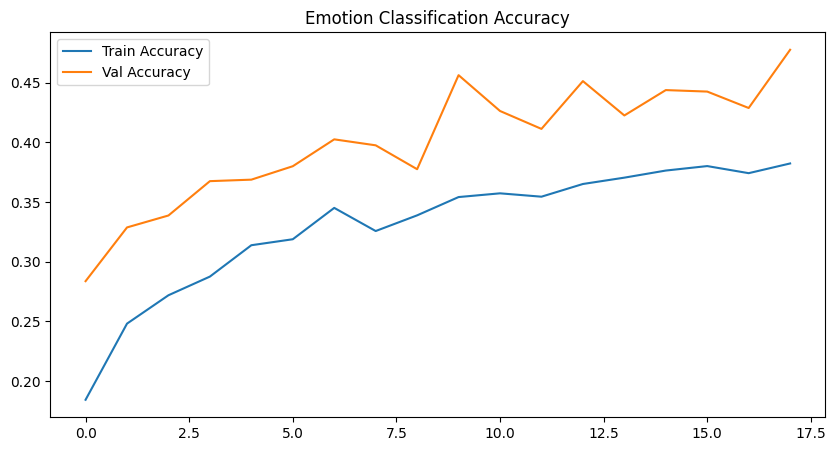

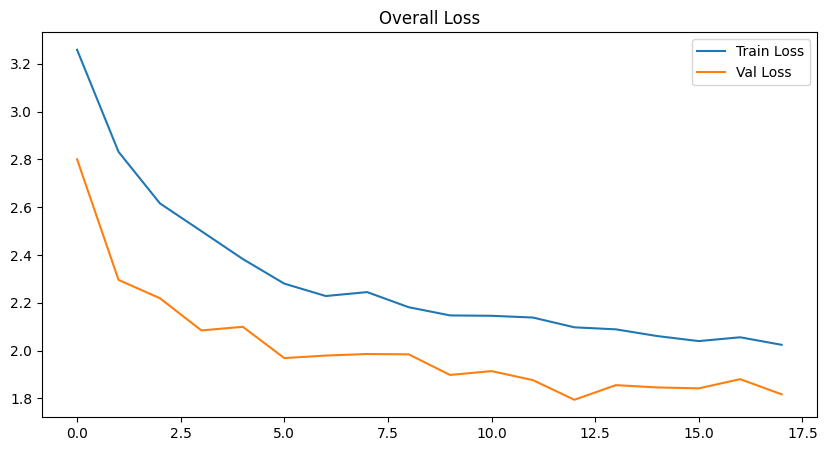

In [25]:

# ----------------------------
# PLOTS
# ----------------------------
plt.figure(figsize=(10,5))
plt.plot(history.history["emotion_output_accuracy"], label="Train Accuracy")
plt.plot(history.history["val_emotion_output_accuracy"], label="Val Accuracy")
plt.title("Emotion Classification Accuracy")
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.title("Overall Loss")
plt.legend()
plt.show()


In [26]:

# ----------------------------
# EVALUATION METRICS
# ----------------------------
# Get predictions
y_pred_expr, y_pred_val, y_pred_aro = model.predict(val_ds)

y_true_expr, y_true_val, y_true_aro = [], [], []
for _, labels in val_ds:
    y_true_expr.append(labels["emotion_output"].numpy())
    y_true_val.append(labels["valence_output"].numpy())
    y_true_aro.append(labels["arousal_output"].numpy())

y_true_expr = np.concatenate(y_true_expr, axis=0)
y_true_val = np.concatenate(y_true_val, axis=0)
y_true_aro = np.concatenate(y_true_aro, axis=0)


C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_372']
Received: inputs=Tensor(shape=(32, 224, 224, 3))
  warnings.warn(msg)


25/25 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step


In [27]:

# Classification metrics
y_true_cls = np.argmax(y_true_expr, axis=1)
y_pred_cls = np.argmax(y_pred_expr, axis=1)

acc = np.mean(y_true_cls == y_pred_cls)
f1 = f1_score(y_true_cls, y_pred_cls, average="weighted")
kappa = cohen_kappa_score(y_true_cls, y_pred_cls)
auc = roc_auc_score(y_true_expr, y_pred_expr, multi_class="ovr")
auc_pr = average_precision_score(y_true_expr, y_pred_expr, average="weighted")


In [28]:

print("\n📊 Classification Metrics:")
print("Accuracy:", acc)
print("F1-Score:", f1)
print("Cohen's Kappa:", kappa)
print("AUC:", auc)
print("AUC-PR:", auc_pr)

# Regression metrics
def regression_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    corr, _ = pearsonr(y_true.flatten(), y_pred.flatten())
    sagr = np.mean(np.sign(y_true) == np.sign(y_pred))
    mean_true, mean_pred = np.mean(y_true), np.mean(y_pred)
    var_true, var_pred = np.var(y_true), np.var(y_pred)
    cov = np.mean((y_true - mean_true) * (y_pred - mean_pred))
    ccc = (2 * cov) / (var_true + var_pred + (mean_true - mean_pred) ** 2)
    return rmse, corr, sagr, ccc



📊 Classification Metrics:
Accuracy: 0.1325
F1-Score: 0.12698246684664885
Cohen's Kappa: 0.010192238780425633
AUC: 0.4999735075079398
AUC-PR: 0.13416242187768276


In [29]:

print("\n📊 Valence Regression Metrics:", regression_metrics(y_true_val, y_pred_val))
print("📊 Arousal Regression Metrics:", regression_metrics(y_true_aro, y_pred_aro))



📊 Valence Regression Metrics: (0.5232407214239242, 0.0035958170145204416, 0.64505625, 8.412512413228751e-11)
📊 Arousal Regression Metrics: (0.4278305502985417, -0.038521844751369896, 0.7515, 3.300452810377513e-11)


In [30]:
# Save full model
model.save("resnet_affect.h5")